# Lanesbot

Lanesbot merupakan layanan Universitas Negeri Semarang berbasis chatbot yang dibuat untuk mempermudah calon mahasiswa dan mahasiswa mencari informasi seputar UNNES.

# Download Dataset from Google Drive

Disini [link dataset](https://drive.google.com/file/d/1uc4Yb43aiK5SL_JJOLxK_U4Zzh1WJi0z/view?usp=share_link)

In [1]:
url = "/content/lanesbot.json"

#Load Google Drive

Setelah kita mengunduh dataset dengan library request url dari link yang kita ketahui maka kita akan menyimpan file data yang kita download di Google Drive dengan cara dibawah ini.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Instalasi Library Pengenalan Suara
Pada proyek AI Chatbot membutuhkan package library yaitu **Speech Recognition** dan **Google Text To Speech** yang harus di install.

In [3]:
!pip install speechRecognition #library Speech Recognition

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.8 MB 1.2 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [4]:
!pip -q install gtts #Google Text To Speech

     |████████████████████████████████| 96 kB 5.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


#Import Library
Tahapan pertama sebelum melakukan eksplorasi dan praproses pada data adalah memasukan library yang akan digunakan untuk menganalisa dataset.

In [5]:
# Import Libraries
import json
import nltk
import time
import random
import string
import pickle
import numpy as np
import pandas as pd
from gtts import gTTS
from io import BytesIO
import tensorflow as tf
import IPython.display as ipd
import speech_recognition as sr 
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D

#Download NLTK Package

In [6]:
# Package sentence tokenizer
nltk.download('punkt')
# Package lemmatization
nltk.download('wordnet')
# Package multilingual wordnet data
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [7]:
# Package sentence tokenizer
nltk.download('punkt')
# Package lemmatization
nltk.download('wordnet')
# Package multilingual wordnet data
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [8]:
# Package sentence tokenizer
nltk.download('punkt')
# Package lemmatization
nltk.download('wordnet')
# Package multilingual wordnet data
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

#Load Dataset Json
Setelah import library, tahapan selanjutnya adalah me-load dataset yang telah disediakan. Dataset yang digunakan berupa format **.json** yang sangat cocok untuk membuat model Chatbot. 

In [9]:
# Importing the dataset
with open('/content/lanesbot.json') as content:
  data1 = json.load(content)

# Mendapatkan semua data ke dalam list
tags = [] # data tag
inputs = [] # data input atau pattern
responses = {} # data respon
words = [] # Data kata
classes = [] # Data Kelas atau Tag
documents = [] # Data Kalimat Dokumen
ignore_words = ['?', '!'] # Mengabaikan tanda spesial karakter

for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      # add to our classes list
      if intent['tag'] not in classes:
        classes.append(intent['tag'])

# Konversi data json ke dalam dataframe
data = pd.DataFrame({"patterns":inputs, "tags":tags})

In [10]:
data

,patterns,tags
0,hallo,greeting
1,hai,greeting
2,halo,greeting
3,hei,greeting
4,hi,greeting
...,...,...
317,Jurusan di Fakultas Hukum,fh_lanesbot
318,Apa saja program studi di Fakultas Hukum?,fh_lanesbot
319,Apa saja program studi di FH,fh_lanesbot
320,Program studi di FH,fh_lanesbot


# Preprocessing The Data

Setelah kita meload data dan mengonversi data json menjadi dataframe. Tahapan selanjutnya adalah praproses pada dataset yang kita gunakan saat ini yaitu dengan cara:
1.   Remove Punctuations (Menghapus Punktuasi)
2.   Lematization (Lematisasi)
3.   Tokenization (Tokenisasi)
4.   Apply Padding (Padding)
5.   Encoding the Outputs (Konversi Keluaran Enkoding)

## Remove Punctuations

Menghapus punktuasi atau tanda baca seperti *special character* yaitu **'!'** (**tanda seru**) **','** (**tanda koma**) **'.'** (**tanda titik sebagai berhenti**) '**?**' (**tanda tanya**) dan tanda baca yang lain. Tahapan ini gunanya untuk mempermudah pemrosesan data teks yang akan kita olah.

In [11]:
# Removing Punctuations (Menghilangkan Punktuasi)
data['patterns'] = data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['patterns'] = data['patterns'].apply(lambda wrd: ''.join(wrd)) 

## Lemmatization (Lematisasi)
Proses melakukan sesuatu menggunakan vocabulary atau kosakata dan analisis morfologi kata-kata untuk menghilangkan *inflectional endings only* dan untuk mengembalikan bentuk *dictionary* (kata dalam kamus) dari sebuah kata yang dikenal sebagai ***lemma***. -Mengambil kata dasar-

In [12]:
# Lematisasi atau Lemmatization
lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))
print (len(words), "unique lemmatized words", words)

146 unique lemmatized words ['&', '(', ')', ',', 'ada', 'adalah', 'afternoon', 'akademik', 'akreditasi', 'apa', 'arti', 'asal', 'bagaimana', 'bahasa', 'bai', 'banyak', 'berapa', 'berhak', 'bingung', 'bro', 'buat', 'bye', 'byee', 'cara', 'dadah', 'daftar', 'dah', 'dalam', 'dan', 'dari', 'dengan', 'di', 'diadakan', 'dimaksud', 'ekonomi', 'fakultas', 'fbs', 'fe', 'fh', 'fik', 'fip', 'fis', 'fmipa', 'ft', 'good', 'hai', 'hallo', 'halo', 'hei', 'hi', 'hukum', 'hy', 'ilmu', 'info', 'inggris', 'ipa', 'itu', 'jalur', 'jumpa', 'jurusan', 'kamu', 'kasih', 'kawan', 'kelompok', 'kemampuan', 'keolahragaan', 'ketentuan', 'lagu', 'lambang', 'lanesbot', 'lirik', 'logo', 'makasih', 'malam', 'mandiri', 'mar', 'masuk', 'matematika', 'materi', 'memilih', 'mengikuti', 'misi', 'morning', 'negeri', 'oleh', 'pada', 'pagi', 'pascasarjana', 'pd', 'pembuatmu', 'pemeringkatan', 'pemilihan', 'penciptamu', 'pendaftaran', 'pendidikan', 'peringkat', 'persyaratan', 'persyaratn', 'peserta', 'potensi', 'prodi', 'program

### **Menyortir Data Kelas Tags**

In [13]:
# sort classes
classes = sorted(list(set(classes)))
print (len(classes), "classes", classes)

52 classes ['daftar_utbk', 'fakultas_lanesbot', 'fbs_akreditasi', 'fbs_info', 'fbs_lanesbot', 'fe_akreditasi', 'fe_info', 'fe_lanesbot', 'fh_info', 'fh_lanesbot', 'fik_akreditasi', 'fik_info', 'fik_lanesbot', 'fip_info', 'fip_lanesbot', 'fis_akreditasi', 'fis_info', 'fis_lanesbot', 'fmipa_akreditasi', 'fmipa_info', 'fmipa_lanesbot', 'ft_akreditasi', 'ft_info', 'ft_lanesbot', 'goodbye', 'greeting', 'jalur_unnes', 'lambang_unnes', 'lanesbot', 'mars_unnes', 'materi_utbk', 'pascasarjana_akreditasi', 'pascasarjana_info', 'pascasarjana_lanesbot', 'pdss_unnes', 'pencipta_lanesbot', 'peringkat_sekolah', 'pertanyaan lain', 'prodi_snmptn', 'sbmptn_unnes', 'sejarah_unnes', 'seleksi_mandiri', 'snmptn_unnes', 'syarat_snmptn', 'syarat_utbk', 'terimakasih', 'tka_utbk', 'tkbi_utbk', 'tps_utbk', 'tujuan_unnes', 'ujian_utbk', 'visimisi_unnes']


### **Mencari Jumlah Keseluruhan Data Teks**

In [14]:
# documents = combination between patterns and intents
print (len(documents), "documents")

2340 documents


## Tokenization (Tokenisasi)
Proses memberikan urutan karakter dan sebuah unit dokumen terdefinisi. Tokenisasi juga merupakan tugas untuk memecah kalimat menjadi bagian-bagian yang disebut dengan '**Token**' dan menghilangkan bagian tertentu seperti tanda baca.

In [15]:
# Tokenize the data (Tokenisasi Data)
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['patterns'])
train = tokenizer.texts_to_sequences(data['patterns'])
train

[[97],
 [98],
 [99],
 [100],
 [101],
 [102],
 [103],
 [104],
 [105],
 [106],
 [107],
 [108],
 [109],
 [110],
 [111],
 [52],
 [3],
 [112],
 [4, 12, 39],
 [39],
 [53, 39],
 [39],
 [53, 113],
 [39, 29, 114, 115, 53, 116],
 [53, 117, 39],
 [54],
 [54, 10],
 [4, 54, 55, 10],
 [54, 10, 12, 4],
 [45],
 [45, 10],
 [62, 45, 10, 4],
 [4, 62, 55, 45, 10],
 [118, 62, 55, 45, 10],
 [119, 56, 10],
 [56],
 [72],
 [56, 10, 12, 4],
 [56, 10],
 [72, 10],
 [46, 10],
 [46],
 [47],
 [4, 46, 10],
 [47, 10],
 [4, 47, 10],
 [46, 47],
 [46, 47, 10],
 [57],
 [4, 57, 10],
 [57, 10],
 [57, 55, 10, 12, 4, 8],
 [63, 64, 30, 31, 10],
 [30, 31, 10],
 [31, 10],
 [48, 73, 31, 10],
 [63, 64, 30, 120, 31, 10],
 [64, 30, 31, 10],
 [30, 31, 10],
 [73, 31, 10],
 [4, 8, 30, 31, 10],
 [4, 12, 16],
 [58],
 [4, 29, 74, 75, 16],
 [16, 40],
 [16],
 [4, 12, 49, 29, 63, 121, 16],
 [4, 12, 49, 76, 16],
 [49],
 [4, 12, 49],
 [49, 40],
 [4, 8, 37, 59, 29, 122, 77, 65, 16],
 [37, 65, 16],
 [37, 16],
 [37, 58],
 [78, 58],
 [123, 29, 77,

## Padding
Proses untuk mengubah setiap sequence agar memiliki panjang yang sama. Pada padding, setiap sequence dibuat sama panjang dengan menambahkan nilai 0 secara suffiks atau prefiks hingga mencapai panjang maksimum sequence. Selain itu padding juga dapat memotong sequence hingga panjangnya sesuai dengan panjang maksimum sequence. 

Proses untuk membuat setiap kalimat pada teks memiliki panjang yang seragam. Sama seperti melakukan resize gambar, agar resolusi setiap gambar sama besar. Untuk menggunakan padding bisa impor library **pad_sequence**. Kemudian buat panggil fungsi pad_sequence() dan masukkan sequence hasil tokenisasi sebagai parameternya.

In [16]:
# Apply padding 
x_train = pad_sequences(train)
print(x_train) # Padding Sequences

[[ 0  0  0 ...  0  0 97]
 [ 0  0  0 ...  0  0 98]
 [ 0  0  0 ...  0  0 99]
 ...
 [ 0  0  0 ...  6  1 36]
 [ 0  0  0 ...  6  1 36]
 [ 0  0  0 ...  1  2 38]]


## Encoding Text
Suatu konversi atau pengkodean yang dimana data kategorik seperti huruf atau data teks menjadi data numerik atau angka menyesuaikan dengan data label yang digunakan. Pada proses tahapan ini, encoding mengubah data teks pada kolom data tags menjadi data numerik dengan bahasa biner komputer yaitu 0 dan 1. 

Tujuan dari encoding ini adalah mempermudah saat proses komputasi data teks dan modelling.

In [17]:
# Encoding the outputs 
le = LabelEncoder()
y_train = le.fit_transform(data[ 'tags'])
print(y_train) #Label Encodings |

[25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 37 37 37 28 28 28 28 35 35
 35 40 40 40 40 29 29 29 29 29 27 27 27 27 27 27 51 51 51 51 51 51 51 51
 49 49 49 49 26 26 26 26 26 26 26 26 26 42 42 42 42 42 34 34 34 34 34 43
 43 43 43 43 43 38 38 38 38 36 36 36 36 39 39 39 39 44 44 44 44 44 30 30
 48 48 48 48 48 48 47 47 47 47 47 46 46 46 46 46 50 50 50  0  0  0 41 41
 41 41 41 41  1  1  1  1  1 24 24 24 24 24 24 24 24 24 45 45 45 45 45 14
 14 14 14 14 14 14 14 14 14 14 14 23 23 23 23 23 23 23 23 23 23  4  4  4
  4  4  4  4  4  4  4 12 12 12 12 12 12 12 12 12 12 17 17 17 17 17 17 17
 17 17 17  7  7  7  7  7  7  7  7  7  7 20 20 20 20 20 20 20 20 20 33 33
 33 33 33 13 13 13 13 13 22 22 22 22 22  3  3  3  3  3 11 11 11 11 11 16
 16 16 16 16  6  6  6  6  6 19 19 19 19 19 32 32 32 32 32  8  8  8  8  8
 21 21 21 21 21 21 21 21  2  2  2  2  2  2  2 10 10 10 10 10 10 10 15 15
 15 15 15 15 15  5  5  5  5  5  5  5 18 18 18 18 18 18 18 31 31 31 31 31
  9  9  9  9  9  9  9  9  9  9]


# Input Length, Output Length and Vocabulary

In [18]:
# input length
input_shape = x_train.shape[1]
print(input_shape)

10


In [19]:
# define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ", vocabulary)

# output length
output_length = le.classes_.shape[0]
print("output length: ", output_length)

number of unique words :  142
output length:  52




```
# This is formatted as code
```

## Save Model Words & Classes


In [20]:
pickle.dump(words, open('words.pkl', 'wb'))
pickle.dump(classes, open('classes.pkl', 'wb'))

## Save Label Encoder & Tokenizer

In [21]:
pickle.dump(le, open('le.pkl','wb'))
pickle.dump(tokenizer, open('tokenizers.pkl','wb'))

## Neural Network Model

In [22]:
# Creating the model (Membuat Modeling)
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,10)(i) # Layer Embedding
x = LSTM(10, return_sequences=True)(x) # Layer Long Short Term Memory
x = Flatten()(x) # Layer Flatten
x = Dense(output_length, activation="softmax")(x) # Layer Dense
model  = Model(i,x)

# Compiling the model (Kompilasi Model)
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

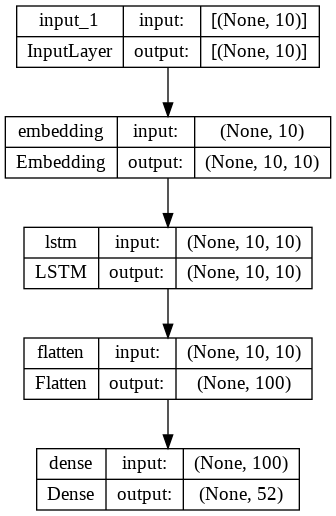

In [23]:
# Visualization Plot Architecture Model (Visualisasi Plot Arsitektur Model)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [24]:
# Training the model (Latih model data sampai 400 kali)
train = model.fit(x_train, y_train, epochs=400)

Epoch 1/400
11/11 [==============================] - 10s 11ms/step - loss: 3.9508 - accuracy: 0.0248
Epoch 2/400
11/11 [==============================] - 0s 8ms/step - loss: 3.9451 - accuracy: 0.0342
Epoch 3/400
11/11 [==============================] - 0s 9ms/step - loss: 3.9399 - accuracy: 0.0342
Epoch 4/400
11/11 [==============================] - 0s 7ms/step - loss: 3.9332 - accuracy: 0.0652
Epoch 5/400
11/11 [==============================] - 0s 6ms/step - loss: 3.9244 - accuracy: 0.0839
Epoch 6/400
11/11 [==============================] - 0s 7ms/step - loss: 3.9123 - accuracy: 0.0932
Epoch 7/400
11/11 [==============================] - 0s 10ms/step - loss: 3.8968 - accuracy: 0.0963
Epoch 8/400
11/11 [==============================] - 0s 7ms/step - loss: 3.8778 - accuracy: 0.0590
Epoch 9/400
11/11 [==============================] - 0s 7ms/step - loss: 3.8590 - accuracy: 0.0528
Epoch 10/400
11/11 [==============================] - 0s 8ms/step - loss: 3.8438 - accuracy: 0.0466
Epoch 

# Model Analysis

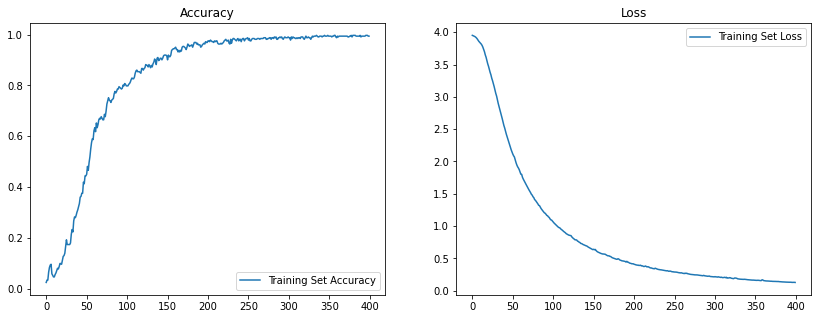

In [25]:
# Plotting model Accuracy and Loss (Visualisasi Plot Hasil Akurasi dan Loss)
# Plot Akurasi
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train.history['accuracy'], label='Training Set Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train.history['loss'], label='Training Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

## Testing Chatbot Dan Tambahkan Suara Pada Chatbot

In [30]:
# Membuat Input Chat
while True:
  texts_p = []
  prediction_input = input('👨‍🦰 Kamu : ')
  
  # Menghapus punktuasi dan konversi ke huruf kecil
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  # Tokenisasi dan Padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input], input_shape)

  # Mendapatkan hasil keluaran pada model 
  output = model.predict(prediction_input)
  output = output.argmax()

  # Menemukan respon sesuai data tag dan memainkan voice bot
  response_tag = le.inverse_transform([output])[0]
  print("🤖 Lanesbot : ", random.choice(responses[response_tag]))
  tts = gTTS(random.choice(responses[response_tag]), lang='id')
  # Simpan model voice bot ke dalam Google Drive
  tts.save('lanesbot.wav')
  time.sleep(0.08)
  # Load model voice bot from Google Drive
  ipd.display(ipd.Audio('lanesbot.wav', autoplay=False))
  print("="*60 + "\n")
  # Tambahkan respon 'goodbye' agar bot bisa berhenti
  if response_tag == "goodbye":
    break

👨‍🦰 Kamu : hi
1/1 [==============================] - 0s 15ms/step
🤖 Lanesbot :  Hai! Lanesbot di sini. Mau tau informasi tentang apa nih?



👨‍🦰 Kamu : bingung
1/1 [==============================] - 0s 17ms/step
🤖 Lanesbot :  Mau tahu prodi di fakultas apa? </br>Lanesbot bantu yaaa. Silahkan ketik prodi *sebutkan nama Fakultas*



👨‍🦰 Kamu : prodi fmipa
1/1 [==============================] - 0s 15ms/step
🤖 Lanesbot :  Fakultas Matematika dan IPA (FMIPA) memiliki satu program studi vokasi dan 13 jurusan berjenjang sarjana. Jurusan tersebut adalah </br>1) Ilmu Lingkungan (S1) </br>2) Sistem Informasi (S1) </br>3) Farmasi (S1) </br>4) Teknik Informatika (S1) </br>5) Pendidikan IPA (S1) </br>6) Biologi (S1) </br>7) Pendidikan Biologi (S1) </br>8) Kimia (S1) </br>9) Pendidikan Kimia (S1) </br>10) Fisika (S1) </br>11) Pendidikan Fisika (S1) </br>12) Statistika Terapan dan Komputasi (D3) </br>13) Matematika (S1) </br>14) Pendidikan Matematika (S1).



👨‍🦰 Kamu : akreditasi fmipa
1/1 [==============================] - 0s 16ms/step
🤖 Lanesbot :  Ilmu Lingkungan (S1) akreditasi B </br>Sistem Informasi (S1) akreditasi B </br>Farmasi (S1) akreditasi B </br>Teknik Informatika (S1) akreditasi B </br>Pendidikan IPA (S1) akreditasi A </br>Biologi (S1) akreditasi A </br>Pendidikan Biologi (S1) akreditasi A </br>Kimia (S1) akreditasi A </br>Pendidikan Kimia (S1) akreditasi A </br></br>Fisika (S1) akreditasi A </br>Pendidikan Fisika (S1) akreditasi A </br>Statistika Terapan dan Komputasi (D3) akreditasi A </br>Matematika (S1) akreditasi A </br>Pendidikan Matematika (S1) akreditasi A.



👨‍🦰 Kamu : bye
1/1 [==============================] - 0s 16ms/step
🤖 Lanesbot :  Bye!


# Save Model

Langkah terakhir adalah men-save model dan scaler object (standardization function) dalam file pickle.

Kita membutuhkan file-file pickle ini pada tahap deployment.